# range-Doppler Maps

### Summary of notebook:

* <b> FMCW Signal Processing </b>
    * A (very) rough introduction to the signal processing required to generated a range-Doppler map.
* <b> Python representation </b>
    * A small "simulation" of a sensor tracking a single target, just a couple measurement frames to demonstrate output format. 
    * range-Doppler map implementation currently uses matplotlib's imshow and is not a satisfactory representation.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import numpy as np
from matplotlib import pylab as plt
from mpl_toolkits import mplot3d
from calc_traj import *
from range_doppler import *
from util import *

## FMCW Signal Processing

I wasn't exactly sure what to do when simulating measurements. I first tried using a very direct method of just placing the simulated range and radial velocity in a matrix (for a given time instance and relative to a sensor) adding some noise and calling it map. However this looked a little to "clean" when compared to actual range-doppler maps, so I assumed getting familiar with the underlying signal processing wasn't a bad way to implement the map. Most of this information has been directly stolen from <a href="#fmcw">[1]</a>, <a href="#wang">[2]</a>.

### Analysis for a continuous wave signal

<b> Remark </b>: <i>Annoyingly MathJax doesn't yet support equation numbering, this will be a fustrating read; rather give up now.</i>

#### Form of the transmitted signal

The frequency of the transmitted signal is swepted linearly over some period, $T$:

$$ f = f_{c} + \frac{B t}{T} $$

Here $B$ is the bandwidth and $f_{c}$ the carrier frequency. The transmitted signal, $v_{t}$, can now be given as:

$$ \begin{eqnarray}
v_{t}(t) &=& \cos ( 2 \pi f t) \\
&=& \cos ( 2 \pi f_{c} t + \frac{\pi B t^{2}}{T} )
\end{eqnarray} $$

The amplitude has been omitted purely for convenience. The $n^{th}$ sweep becomes:

$$ v^{n}_{t}(t) = \cos ( 2 \pi f_{c} t + \frac{\pi B (t - n T)^{2}}{T} ) $$

The time delay, $t_{d}$, between the transmitted and received signal can be defined in terms of range and velocity:
$$ t_{d} = 2 \left( \frac{R + V t}{c} \right) $$

While the amplitude of the transmitted signal has been omitted, it can be said that the received signal's amplitude is at least proportional to $\frac{1}{R^{2}}$. The return from the $n^{th}$ sweep can be given by:

$$v_{r}^{n}(t) = \frac{1}{R^{2}} \cos (2 \pi f_{c} \left[ t - t_{d} \right] + \frac{ \pi B \left( t - t_{d} - n T \right)^{2} } {T} ) $$ 

#### Mixing of the returned and transmitted signals

The transmitted and returned signal are now mixed, giving:

$$ v_{m}(t) = v_{r}(t) v_{t}(t) $$

Which, using several trigonometric identities, can be reduced to the following:

$$v_{m}^{n}(t) = \frac{1}{R^{2}} \cos \left( \frac{4 \pi f_{c} t_{d} }{c} + \frac{2 \pi B t_{d} (t - nT)}{T} - \frac{\pi B t_{d}^{2} }{T}  \right)$$

Rewriting $v_{m}^{n}(t)$ in terms of range, $R$, and radial velocity, $V$:

$$v_{m}^{n}(t) = \frac{1}{R^{2}} \cos \left( \frac{4 \pi f_{c} (R + V t) }{c} + \frac{2 \pi B (R + V t) (t - nT)}{T} - \frac{\pi B (R + V t)^{2} }{T}  \right)$$

This allows the mixed signal to processed to directly give estimates of the range and velocity.

#### Processing the mixed signal

A range-Doppler map is generated by taking an FFT of each succesive sweep of the mixed signal and arranging them in rows as a matrix and then taking the FFT of this matrix's columns. 

##### FFTs over each sweep

Assume the $n^{th}$ sweep takes a time, $t'$:

$$ t = n T + t'$$

Ignoring the constant and terms quadratic in $t'$, the mixed signal, $v_{m}^{n}(t)$, can be reduced to:

$$v_{m}^{n}(t) = \frac{1}{R^{2}} \cos \left( 2 \pi \{ f_{p} t' + f_{D} T \} \right) $$

Here the Doppler and peak frequencies, $f_{D}$ and $f_{p}$ respectfully, are given by:

$$ \begin{eqnarray}
f_{D} &=& \frac{2 f_{c} V}{c} \\
f_{p} &=& \frac{2 B R}{c T} + f_{D} + \frac{2 B n V}{c} \\
&\approx& \frac{2 B R}{c T}
\end{eqnarray} $$

An M-point FFT is taken over the reduced mixed signal $v_{m}^{n}(t)$, which ideally produces:

$$ V_{m}^{n}(f) = \frac{e^{j 2 \pi f_{D} n T} }{R^{2}} \delta \left[f - f_{p} \right] + \frac{e^{-j 2 \pi f_{D} n T} }{R^{2}} \delta \left[f + f_{p} \right] $$

Practically speaking $v_{m}^{n}(t)$ is sampled $M$ many times in per sweep with a time resolution, $\delta t$:

$$\delta t = \frac{T}{M} $$

The FFT of these samples as points at the following frequencies:

$$-\frac{M}{2T}, \left( -\frac{M}{2} + 1 \right)\frac{1}{T}, \dots , 0, \dots, \left( \frac{M}{2} - 1 \right)\frac{1}{T} $$

These frequencies correspond to range cells centered on:

$$\frac{cM}{4B}, \left( \frac{M}{2} - 1 \right)\frac{c}{2B}, \dots , 0, \dots, \left( \frac{M}{2} - 1 \right)\frac{c}{2B}, \frac{cM}{4B} $$

This allows a range resolution to be easily defined:

$$ \Delta R = \frac{c}{2B} $$

For a specified maximum range, this allows the $M$ to be defined as:

$$M = \frac{4 B R_{MAX}}{c} $$

And the baseband frequency to given as:

$$f_b = \frac{2 B R_{MAX}}{c T} $$

The mixed signal, $v_{m}^{n}(t)$, is sampled at the Nyquist frequency:

$$\delta t = \frac{c T}{4 B R_{MAX}} = \frac{1}{2B} $$

This means any signal beyond $R_{LIM}$ cannot be uniquely determined due to aliasing. Here,

$$R_{LIM} = \frac{c T} {2} $$

##### The second set of FFTs

The total $N$ FFTs of the  $v_{m}^{n}(t)$ sweeps are now arranged in rows as a matrix, 

$$
\begin{matrix}
 & f = -f_{b} & \cdots & f = -f_{p} & \cdots & f = f_{p} & \cdots & f= f_{b}  \\
i = 0 & 0 & 0 & \frac{1}{R^{2}} & 0 & \frac{1}{R^{2}}  & 0 & 0 \\
i = 1 & 0 & 0 & \frac{e^{-j 2 \pi f_{D} T} }{R^{2}} & 0 & \frac{e^{j 2 \pi f_{D} T} }{R^{2}} & 0 & 0 \\
\cdots & \cdots & \cdots & \cdots & \cdots & \cdots  &\cdots & \cdots \\
i = N & 0 & 0 & \frac{e^{-j 2 \pi f_{D} N T} }{R^{2}} & 0 & \frac{e^{j 2 \pi f_{D} N T} }{R^{2}}  & 0 & 0 \\
\end{matrix}
$$

Taking $N$ point FFTs over this matrix's columns produces:

$$
\begin{matrix}
 & f = -f_{b} & \cdots & f = -f_{p} & \cdots & f = f_{p} & \cdots & f= f_{b}  \\
f = -\frac{1}{2 T} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
f = -f_{D} & 0 & 0 & \frac{1}{R^{2}} & 0 & 0 & 0 & 0 \\
\cdots & \cdots & \cdots & \cdots & \cdots & \cdots  &\cdots & \cdots \\
f = f_{D} & 0 & 0 & 0 & 0 & \frac{1}{R^{2}} & 0 & 0 \\
f = \frac{1}{2 T} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{matrix}
$$

As it can be seen the frequency resolution of the second set of FFTs is $\frac{1}{N T}$, this has a corresponding velocity resolution:

$$\Delta V = \frac{c}{2 N T f_{c}}$$

The number of sweeps required for a given velocity resolution is given by:

$$N = \frac{c}{2 \Delta V T f_{c}} $$

To avoid aliasing the sampling rate for the seond set of FFTs must be greater or reaul to $T$, where:

$$ T = \frac{c}{4 f_{c} V_{MAX}} $$

<b> Remark </b>: <i> This may all seem like incoherent rambling, but it leads to equations which fully specify the "system" for a given $R_{MAX}$, $\Delta R$, $V_{MAX}$ and $\Delta V$. After sepcifiying the maximum range and velocity and their resolutions (and the carrier frequency) all that should be required is sampling the mixed signal $v_{m}^{n}(t)$ N-many times and performing the 2D FFT. </i>

<b> Super-meta remark </b>: <i> None of the above has worked yet, so I guess it's more complicated than that. </i>.


#### CPI considerations

CPI is not mentioned in any of the two articles I read as it may be obvious, but for (truly) real-time system all of the above calculations must take place within the CPI. However, this may not be a strict requirement for a satisfactory system. Anyhow, since this simulation is offline the CPI have no influence on it.

## Python representation of a range-Doppler map

<b> Remark </b>: <i> This section is a disaster </i>.

The goal of this section is to establish an appropriate Python representation of a range-Doppler map. As each sensor will produce a map for a particular sample time (currently the CPI, until I know better) an initial approach is to produce a correct map for a single target for a single time step. I have made massive assumptions about the linearity of this process and assume a map (essentially a matrix) for multiple targets is simply the sum of a single target's map.

If this representation is satisfactory it will then be extended to multiple targets and include noise. This obviously means adding noise to the sensor measurements as well as accounting for slow moving objects (trees and the like) clustering around $0$ $m/s$. 

I do not yet know the particulars of EMSS's actual system, MATLAB's range-doppler suite examples offered some typical FMCW parameters. The following parameters were chosen:

$$ \begin{eqnarray}
f_{c} &=& 1 \ GHz \\
\Delta R &=& 2 \ m \\
R_{MAX} &=& 250 \ m \\
\Delta V &=& 2 \ m/s \\
V_{MAX} &=& 100 \ m/s 
\end{eqnarray} $$

All other parameters will derive from these specifications. The same sensor locations and CPI were used as the Kalman filtering simulation.

In [2]:
_, p0, v0, w0 = load_clubs('clubs.csv')
sensor_locations = np.array([[-10, 28.5, 1], [-15, 30.3, 3],
                             [200, 30, 1.5], [220, -31, 2],
                             [-30, 0, 0.5], [150, 10, 0.6]])

cpi = 75e-3
t_sim = np.arange(0, 12, cpi)
t, p, v = calc_traj(p0[0, :], v0[0, :], w0[0, :], t_sim)
r_d = range_doppler(sensor_locations, p, v)

In [3]:
c = 3e8   #Speed of light
f_c = 1e9 #Carrier frequency

del_r = 2   #Range resolution
r_max = 250 #Maximum range

del_v = 2   #Velocity resolution
v_max = 100 #Maximum velocity

In [4]:
B = c/(2*del_r) #Bandwidth
T = c/(4*f_c*v_max) #Sweep time
f_b = (2*B*r_max)/(c*T) #Baseband frequency

M = int((4*B*r_max)/c) #Samples per sweep
N = int(c/(2*del_v*T*f_c)) #Number of sweeps

After the simulation is setup, I chose a single range and radial velocity measurement, $r_{1}$ and $v_{2}$ respectively, from sensor 1 at time $t_{0}$. From this the peak and Doppler frequencies are calculated.

In [5]:
v_1 = r_d[0, :, 0][0]
r_1 = r_d[0, :, 1][0]

f_d = (2*f_c*v_1)/c
f_p = (2*B*r_1)/(c*T)

print(v_1, r_1, f_d, f_p)

33.5370999778 32.3842012634 223.580666519 21589.4675089


For the given time resolution, $\delta t$, the mixed signal $v_{m}^{n}(t) = \frac{1}{R^{2}} \cos \left( 2 \pi \{ f_{p} t' + f_{D} T \} \right)$ is sampled $M$-many times for $N$-many sweeps. Afterwhich a 2D FFT is taken of the resulting matrix.

The matrix is then plotted using matplotlib's imshow and is subject to its quirks. Obviously this particular representation does not mean much but gives a neat method of viewing the underlying matrix. 

<b> Remark </b>: <i> The results are as the theory predicted (it would be strange is they weren't), but I am not sure if I am interpreting them correctly. Are the range cells corresponding to negative frequencies necessary ? If I discard them I shouldn't lose the direction of the velocity. To test this I plotted the matrix below using only half the range values, but the plot axes don't line up with what their frequencies and I not sure if this is just imshow being annoying.</i>

In [6]:
dt = np.linspace(0, T, M)

samples = np.empty((N, M))

for i in np.arange(0, N):
    samples[i, :] = (1.0/(r_1**2))*np.cos(2*np.pi*(f_p*dt + f_d*i*T))

In [7]:
fft = np.abs(np.fft.fft2(samples, axes=(0, 1)))

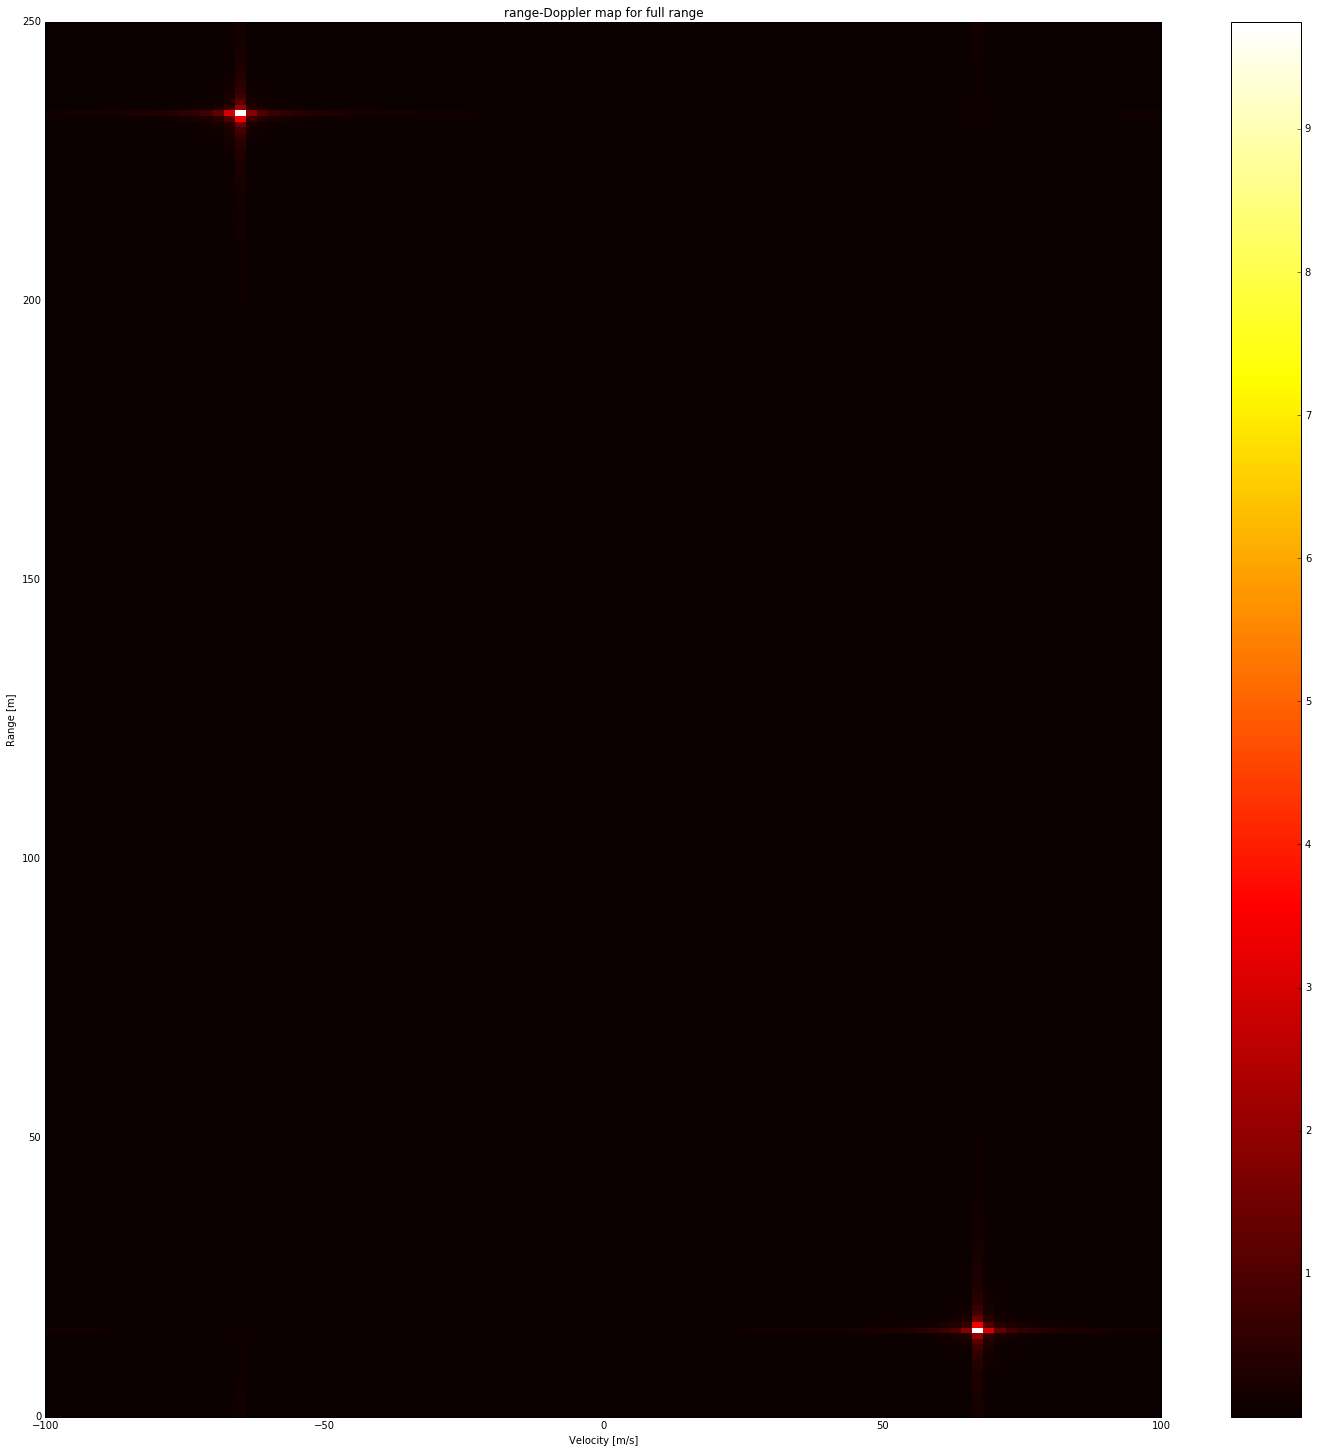

In [13]:
plt.figure(figsize = (25, 25))
plt.imshow(fft.T, cmap='hot', extent = [-N, N, 0, M], interpolation='nearest')
plt.xlabel('Velocity [m/s]')
plt.ylabel('Range [m]')
plt.title('range-Doppler map for full range')
plt.colorbar()

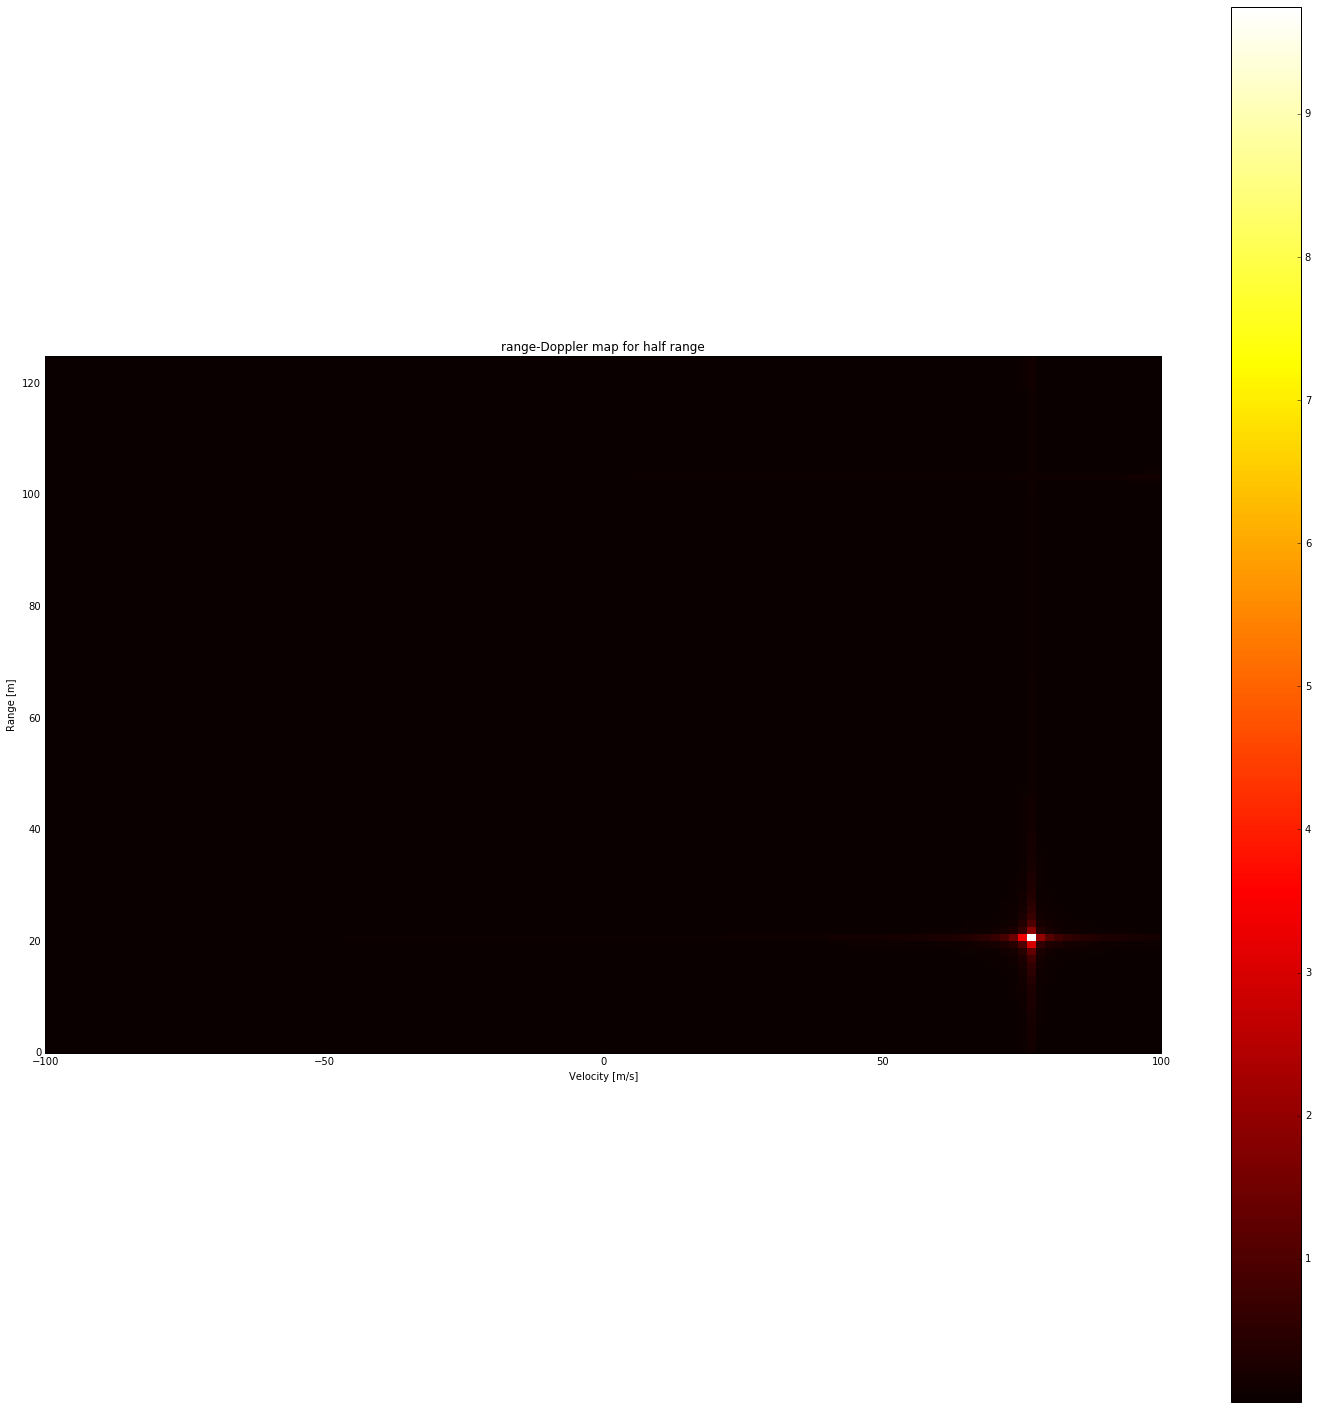

In [21]:
Z = int(M/2)
half_range = fft[:, Z:-1]

plt.figure(figsize = (25, 25))
plt.imshow(half_range, cmap='hot', extent = [-N, N, 0, Z], interpolation='nearest')
plt.xlabel('Velocity [m/s]')
plt.ylabel('Range [m]')
plt.title('range-Doppler map for half range')
plt.colorbar()

## References

<ol type="1">
  <li><a name="fmcw">B.J Lipa and D.E Barrick. <i>"FMCW Signal Processing"</i>. <a href="http://codar.com/images/about/1990LipaBarr_FMCW.pdf">http://codar.com/images/about/1990LipaBarr_FMCW.pdf</a>, 1990 [21 March 2016]. </a></li>
  
    <li><a name="wang">Wang et. al."Range-Doppler image processing in linear FMCW radar and
FPGA based real-time implementation", <i>Journal of Communication and Computer</i>, vol. 6, pp. 55-59, Apr. 2009.</a></li>
    
</ol> 